# COVID - 19 short term prediction

https://www.kaggle.com/c/covid19-global-forecasting-week-2


In [2]:
import pandas as pd
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt

# Utils & variables

In [3]:
raw  = pd.read_csv('data/covid_19_data.csv')
border_date = '2020-04-20'
days_from_today = 5

In [4]:
def line_plot(df, title, xlabel=None, ylabel="Cases",
              h=None, v=None, xlim=(None, None), ylim=(0, None),
              math_scale=True, x_logscale=False, y_logscale=False, y_integer=False,
              show_legend=True, bbox_to_anchor=(1.02, 0),  bbox_loc="lower left"):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    # Scale
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if x_logscale:
        ax.set_xscale("log")
        if xlim[0] == 0:
            xlim = (None, None)
    if y_logscale:
        ax.set_yscale("log")
        if ylim[0] == 0:
            ylim = (None, None)
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    # Set metadata of figure
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    if show_legend:
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=bbox_loc, borderaxespad=0)
    else:
        ax.legend().set_visible(False)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle=":")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle=":")
    plt.tight_layout()
    plt.show()

# Data clearing and visualization

In [5]:
#https://www.kaggle.com/lisphilar/covid-19-data-with-sir-model/notebook#Dataset-and-tools

data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"].replace(
    {
        "Mainland China": "China",
        "Hong Kong SAR": "Hong Kong",
        "Taipei and environs": "Taiwan",
        "Iran (Islamic Republic of)": "Iran",
        "Republic of Korea": "South Korea",
        "Republic of Ireland": "Ireland",
        "Macao SAR": "Macau",
        "Russian Federation": "Russia",
        "Republic of Moldova": "Moldova",
        "Taiwan*": "Taiwan",
        "Cruise Ship": "Others",
        "United Kingdom": "UK",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "St. Martin": "Saint Martin",
        "Cote d'Ivoire": "Ivory Coast",
        "('St. Martin',)": "Saint Martin",
        "Congo (Kinshasa)": "Congo",
        "Congo (Brazzaville)": "Congo",
        "The, Bahamas": "Bahamas",
    }
)
df["Province"] = df["Province"].fillna("-").replace(
    {
        "Cruise Ship": "Diamond Princess",
        "Diamond Princess cruise ship": "Diamond Princess"
    }
)
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped['Place'] = ncov_df_ungrouped['Country'] + ' '  + ncov_df_ungrouped['Province']
ncov_df_ungrouped = ncov_df_ungrouped.drop('Country', 1)
ncov_df_ungrouped = ncov_df_ungrouped.drop('Province', 1)
ncov_df_ungrouped.tail()

,Date,Confirmed,Infected,Deaths,Recovered,Place
18322,2020-04-24,473,466,7,0,US Wyoming
18323,2020-04-24,76,0,3,73,China Xinjiang
18324,2020-04-24,11,11,0,0,Canada Yukon
18325,2020-04-24,185,3,2,180,China Yunnan
18326,2020-04-24,1268,11,1,1256,China Zhejiang


In [6]:
training = ncov_df_ungrouped[(ncov_df_ungrouped['Date'] > '2013-01-01') & (ncov_df_ungrouped['Date'] < border_date)]
test = ncov_df_ungrouped[ncov_df_ungrouped['Date'] >= border_date]

In [7]:
places = ncov_df_ungrouped['Place'].unique()
places

array(['China Anhui', 'China Beijing', 'China Chongqing', 'China Fujian',
       'China Gansu', 'China Guangdong', 'China Guangxi', 'China Guizhou',
       'China Hainan', 'China Hebei', 'China Heilongjiang', 'China Henan',
       'Hong Kong Hong Kong', 'China Hubei', 'China Hunan',
       'China Inner Mongolia', 'China Jiangsu', 'China Jiangxi',
       'China Jilin', 'China Liaoning', 'Macau Macau', 'China Ningxia',
       'China Qinghai', 'China Shaanxi', 'China Shandong',
       'China Shanghai', 'China Shanxi', 'China Sichuan', 'Taiwan Taiwan',
       'China Tianjin', 'China Tibet', 'US Washington', 'China Xinjiang',
       'China Yunnan', 'China Zhejiang', 'Japan -', 'Thailand -',
       'South Korea -', 'Singapore -', 'Philippines -', 'Malaysia -',
       'Vietnam -', 'Australia -', 'Mexico -', 'Brazil -', 'Colombia -',
       'US Chicago', 'France -', 'US Illinois', 'Nepal -',
       'US California', 'US Arizona', 'Canada Ontario', 'Cambodia -',
       'Sri Lanka -', 'Ivory Coas

In [8]:
germany =  ncov_df_ungrouped[ncov_df_ungrouped['Place'] == 'Germany -']
germany_test =  test[test['Place'] == 'Germany -']
germany_training =  training[training['Place'] == 'Germany -']


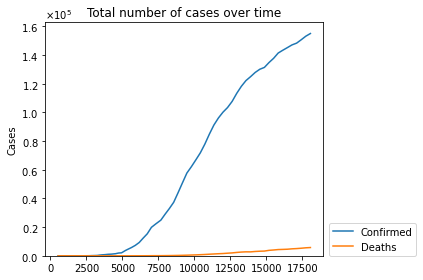

In [9]:
cols = ['Confirmed', 'Deaths']
line_plot(germany[cols], "Total number of cases over time")

# Simple linear model
it tries to fit one of commonly used functions like sigmoid function, exponenta or polynomial. The decision which function fits the best is made by minimizing MSE.

In [10]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sigmoid(x, N, k, x0):
    return N / (1 + np.exp(-k * (x - x0)))

def exponenta(x, a , b, c, x0):
    return a * np.power(b, x-x0) + c

def poli(x, a , b, c, d):
    return a * np.power(x, 3) + b * np.power(x, 2) + c * np.power(x, 1) + d

def getError(x, y, func, params):
    N = len(x)
    return 1/N * (np.square(y - func(x, *params)).sum())

functions = [sigmoid, exponenta, poli]

def getDataSet(dataset, label):
    data = dataset[label]
    y = data.to_numpy()
    if y[len(y) -1 ] > 500:
        y0 = np.where(y > 100)[0][0]
        y = y[y0:]
    x = np.array(list(range(0,len(y))))
    return (x,y)

def fitFuntion(dataset, label, verbose = False): 
    x, y = getDataSet(dataset, label)
    bestFitFunc = {}
    minError = -1
    fitting = []
    for f in functions:
        try: 
            popt, pcov = curve_fit(f, x, y)
        except:
            continue
        err = getError(x, y, f, popt)
        ob = {'error': err, 'function': f, 'pcov': pcov, 'popt': popt}
        fitting.append(ob)
        if minError == -1 or err < minError:
            minError = err 
            bestFitFunc = ob
    if verbose:
        for res in fitting:
            print("function: " +  str(res['function'].__name__) + " err: " + str(res['error']) +  " params: ", str(res['popt']))
    return bestFitFunc
def plotResult(dataset, label, bestFitFunc):
    x, y = getDataSet(dataset, label)
    func = bestFitFunc['function']
    popt = bestFitFunc['popt']
    plt.axvline(x=len(x)-days_from_today, ymin=0, ymax=y[len(y)-1], color='r')
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, func(x, *popt), 'g--', label='estimation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

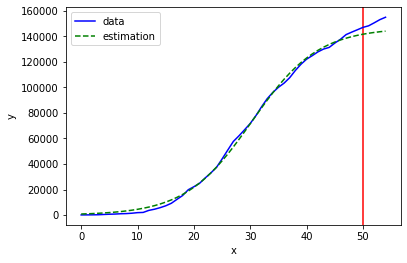

Used Method: sigmoid


In [11]:
fit = fitFuntion(germany_training, 'Confirmed')
plotResult(germany, 'Confirmed', fit)
print("Used Method: " + fit['function'].__name__)

/home/jakub/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


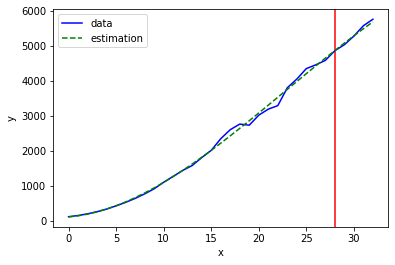

Used Method: poli


In [11]:
fit = fitFuntion(germany_training, 'Deaths')
plotResult(germany, 'Deaths', fit)
print("Used Method: " + fit['function'].__name__)

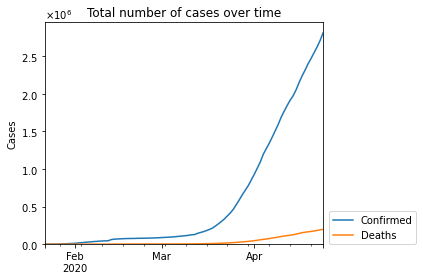

,Confirmed,Infected,Deaths,Recovered
Date,,,,
2020-01-22,555,510,17,28
2020-01-23,653,605,18,30
2020-01-24,941,879,26,36
2020-01-25,1438,1357,42,39
2020-01-26,2118,2010,56,52
...,...,...,...,...
2020-04-20,2472259,1656535,169986,645738
2020-04-21,2549123,1692721,176583,679819
2020-04-22,2623960,1731200,183066,709694


In [12]:
global_dt = ncov_df_ungrouped.drop('Place', 1).groupby(['Date']).sum()
global_training = global_dt[(global_dt.index > '2013-01-01') & (global_dt.index < border_date)]
line_plot(global_dt[cols], "Total number of cases over time")
global_dt

function: sigmoid err: 1168243624.433547 params:  [3.12504419e+06 1.12385625e-01 7.77153838e+01]
function: exponenta err: 7133345786.001274 params:  [ 1.38035624e+02  1.06179322e+00 -4.09964465e+04 -7.67429653e+01]
function: poli err: 2707559198.986719 params:  [ 1.06448327e+01 -8.02648753e+02  1.78541650e+04 -6.00355276e+04]


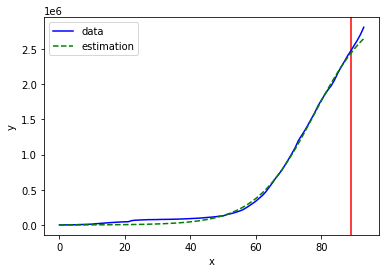

Used Method: sigmoid
Error : 1168243624.433547


In [13]:
fit = fitFuntion(global_training, 'Confirmed', verbose = True)
plotResult(global_dt, 'Confirmed', fit)
print("Used Method: " + fit['function'].__name__)
print("Error : " + str(fit['error']))

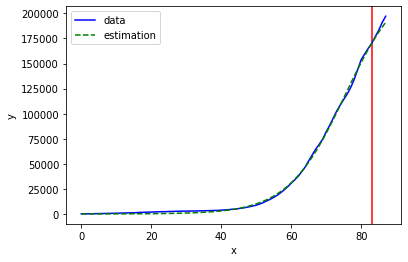

Used Method: sigmoid
Error : 1973162.9550586846


In [14]:
fit = fitFuntion(global_training, 'Deaths')
plotResult(global_dt, 'Deaths', fit)
print("Used Method: " + fit['function'].__name__)
print("Error : " + str(fit['error']))

# Enchancment for global model (measure model based on sum of predictions for each country)

In [15]:
def fillToN(y, N):
    w = np.zeros(N - len(y))
    return np.concatenate((w,y))    
    
def getErrorGlobal(y, agg):
    N = len(y)
    print(N)
    return 1/N * (np.square(y - agg).sum())
    
def predict_global(label):
    print("Nuber of separate places used in estimation: " + str(len(places)))
    funcMap = {'sigmoid': 0, 'poli': 0, 'exponenta': 0}
    N = 110
    x, y = getDataSet(global_dt, label)
    x = list(range(N))
    y = fillToN(y, N)
    agg = np.zeros(N)
    for place in places:
        dt = ncov_df_ungrouped[ncov_df_ungrouped['Place'] == place]
        dt_training =  training[training['Place'] ==  place]
        fit = fitFuntion(dt_training, label)
        a, b = getDataSet(dt, label)
        if 'function' in fit:
            func = fit['function']
            funcMap[func.__name__] += 1 
            popt = fit['popt']
            y_fited = fillToN(func(a, *popt), N)
            agg = agg + y_fited

    print("Square error: " + str(getErrorGlobal(y, agg)))
    print("function usage in fitting: ")
    print(funcMap)
    plt.axvline(x=len(x)-days_from_today, ymin=0, ymax=y[len(y)-1], color='r')
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, agg, 'g--', label='estimation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

Nuber of separate places used in estimation: 514


/home/jakub/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/jakub/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/jakub/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


110
Square error: 78655822.37444298
function usage in fitting: 
{'sigmoid': 51, 'poli': 331, 'exponenta': 60}


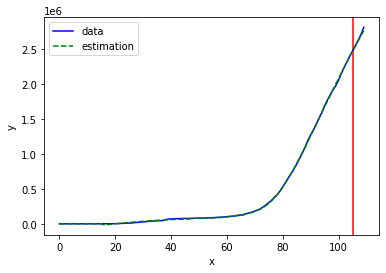

In [16]:
predict_global('Confirmed')

Nuber of separate places used in estimation: 514


/home/jakub/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """
/home/jakub/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/jakub/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in power
  


110
Square error: 1779285.7375481683
function usage in fitting: 
{'sigmoid': 146, 'poli': 146, 'exponenta': 159}


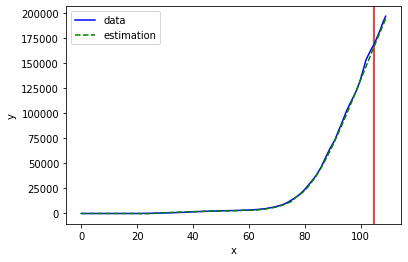

In [17]:
predict_global('Deaths')

# Simple XGBRegressor

This approach turned out to be innefective, and gave no nearly valid results, it is left here for reference but it won't be used in final summary

In [73]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from xgboost import XGBRegressor

In [74]:
def prepareDataForXGBRegressor(data):
    year = []
    month = []
    day = []
    for el in data.Date:
        e = str(el).split(" ")[0].split("-")
        year.append(e[0])
        month.append(e[1])
        day.append(e[2])
    data['Month'] = month
    data['Day'] = day
    del data['Date']
    del data['Recovered']
    data['Confirmed'] = data['Confirmed'].apply(int)
    data['Infected'] = data['Infected'].apply(int)
    data['Deaths'] = data['Deaths'].apply(int)
    data['Month'] = data['Month'].apply(int)
    data['Day'] = data['Day'].apply(int)

In [75]:
lb = LabelEncoder()
scaler = MinMaxScaler()

In [76]:
XGBtraining = training.copy()
prepareDataForXGBRegressor(XGBtraining)
XGBtrainingLabeled = XGBtraining.copy()
XGBtraining['Place'] = lb.fit_transform(XGBtraining['Place'])

confirmed = XGBtraining.Confirmed
deaths = XGBtraining.Deaths
infected = XGBtraining.Infected

del XGBtraining['Confirmed']
del XGBtraining['Infected']
del XGBtraining['Deaths']

XGBtraining

,Place,Month,Day
0,74,1,22
1,75,1,22
2,76,1,22
3,77,1,22
4,78,1,22
...,...,...,...
16724,498,4,19
16725,102,4,19
16726,67,4,19
16727,103,4,19


In [77]:
XGBtestWithAnswers = test.copy()
prepareDataForXGBRegressor(XGBtestWithAnswers)
XGBtest = XGBtestWithAnswers.copy()
del XGBtest['Confirmed']
del XGBtest['Infected']
del XGBtest['Deaths']
XGBtest['Place'] = lb.transform(XGBtest['Place'])
XGBtest

,Place,Month,Day
16729,1,4,20
16730,2,4,20
16731,3,4,20
16732,4,4,20
16733,5,4,20
...,...,...,...
18322,498,4,24
18323,102,4,24
18324,67,4,24
18325,103,4,24


In [78]:
x_train = scaler.fit_transform(XGBtraining.values)
x_test = scaler.transform(XGBtest.values)

In [79]:
# minErr = 1000000000
# minD = 0
# minE = 0
# estimators = list(range(100,2000, 100))
# depth = list(range(4,6,1))
# for d in depth:
#     for e in estimators: 
#         rf = XGBRegressor(n_estimators = e , random_state = 0 , max_depth = d)
#         rf.fit(x_train,confirmed)
#         cases_pred = rf.predict(x_test)
#         t = XGBtestWithAnswers.copy()
#         t["predicted_confirmed"] = cases_pred
#         germany = t[t['Place'] == 'Germany -']
#         N = len(germany.predicted_confirmed)
#         err = 1/N * (np.square(germany.predicted_confirmed - germany.Confirmed)).sum()
#         print(d, e, err)
#         if(err< minErr):
#             print("NEW MIN !!!!!" + str(err))
#             minErr = err
#             minD = d
#             minE = e

In [80]:
rf1 = XGBRegressor(n_estimators = 1800 , random_state = 0 , max_depth = 4)
rf1.fit(x_train,confirmed)

rf = XGBRegressor(n_estimators = 200000)
rf.fit(x_train,confirmed)


rfd = XGBRegressor(n_estimators = 1800 , random_state = 0 , max_depth = 4)
rfd.fit(x_train,deaths)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1800, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [81]:
cases_pred1 = rf1.predict(x_test)
cases_pred = rf.predict(x_test)
deths_pred = rfd.predict(x_test)

cases_pred_train1 = rf1.predict(x_train)
cases_pred_train = rf.predict(x_train)
deths_pred_train = rfd.predict(x_train)
cases_pred

array([ 927.9331  ,  575.9799  , 2576.4434  , ...,    3.521155,
        -85.050186,  885.3424  ], dtype=float32)

In [82]:
XGBtestWithAnswers["predicted_confirmed"] = cases_pred
XGBtestWithAnswers["predicted_confirmed1"] = cases_pred1
XGBtestWithAnswers["predicted_deaths"] = deths_pred
XGBtestWithAnswers

,Confirmed,Infected,Deaths,Place,Month,Day,predicted_confirmed,predicted_confirmed1,predicted_deaths
16729,1026,855,36,Afghanistan -,4,20,927.933105,882.649841,28.137831
16730,584,231,26,Albania -,4,20,575.979919,726.959900,31.367586
16731,2718,1235,384,Algeria -,4,20,2576.443359,2429.119385,360.177399
16732,717,432,37,Andorra -,4,20,715.620361,867.869202,39.002972
16733,24,16,2,Angola -,4,20,21.994886,168.818420,7.138822
...,...,...,...,...,...,...,...,...,...
18322,473,466,7,US Wyoming,4,24,382.699341,890.417297,11.443136
18323,76,0,3,China Xinjiang,4,24,-180.110153,30.577114,-0.169880
18324,11,11,0,Canada Yukon,4,24,3.521155,191.231125,17.806404
18325,185,3,2,China Yunnan,4,24,-85.050186,160.084244,2.600094


In [83]:
XGBtrainingLabeled["predicted_confirmed"] = cases_pred_train
XGBtrainingLabeled["predicted_confirmed1"] = cases_pred_train1
XGBtrainingLabeled["predicted_deaths"] = deths_pred_train
XGBtrainingLabeled

,Confirmed,Infected,Deaths,Place,Month,Day,predicted_confirmed,predicted_confirmed1,predicted_deaths
0,1,1,0,China Anhui,1,22,0.991609,47.616783,1.580058
1,14,14,0,China Beijing,1,22,14.012419,-40.150955,1.390967
2,6,6,0,China Chongqing,1,22,5.995695,87.248802,2.024722
3,1,1,0,China Fujian,1,22,0.992737,-8.101639,0.362955
4,0,0,0,China Gansu,1,22,0.014883,-45.289734,0.266226
...,...,...,...,...,...,...,...,...,...
16724,313,311,2,US Wyoming,4,19,313.028198,769.080811,18.579535
16725,76,0,3,China Xinjiang,4,19,76.036522,75.544449,5.325396
16726,9,9,0,Canada Yukon,4,19,8.983722,182.635025,10.558747
16727,184,4,2,China Yunnan,4,19,183.934708,205.051666,7.096083


# Germany

In [84]:
germany =  XGBtrainingLabeled[XGBtrainingLabeled['Place'] == 'Germany -']
N = len(germany.predicted_confirmed)
germany

,Confirmed,Infected,Deaths,Place,Month,Day,predicted_confirmed,predicted_confirmed1,predicted_deaths
530,8,8,0,Germany -,2,1,8.001757,-135.643600,44.028427
595,10,10,0,Germany -,2,2,10.004848,148.364685,4.514588
662,12,12,0,Germany -,2,3,11.991415,23.535242,7.138055
730,12,12,0,Germany -,2,4,11.992772,-116.081131,52.177158
800,12,12,0,Germany -,2,5,12.038644,114.760834,-30.830944
...,...,...,...,...,...,...,...,...,...
15190,134753,58349,3804,Germany -,4,15,134752.828125,135941.890625,3754.821045
15510,137698,56646,4052,Germany -,4,16,137698.015625,137827.218750,3917.670166
15830,141397,53931,4352,Germany -,4,17,141397.156250,140395.562500,4246.233887
16150,143342,53483,4459,Germany -,4,18,143341.859375,141100.453125,4323.441406


In [85]:
1/N * (np.square(germany.predicted_confirmed - germany.Confirmed)).sum()

0.014199713816047227

In [86]:
1/N * (np.square(germany.predicted_confirmed1 - germany.Confirmed)).sum()

3449933.553320088

In [87]:
1/N * (np.square(germany.predicted_deaths - germany.Deaths)).sum()

3408.1069465002915

In [88]:
germany = XGBtestWithAnswers[XGBtestWithAnswers['Place'] == 'Germany -']
N = len(germany.predicted_confirmed)
germany

,Confirmed,Infected,Deaths,Place,Month,Day,predicted_confirmed,predicted_confirmed1,predicted_deaths
16790,147065,50703,4862,Germany -,4,20,146754.890625,145320.078125,4610.037598
17110,148291,48058,5033,Germany -,4,21,143048.968750,146171.156250,4615.177734
17430,150648,45969,5279,Germany -,4,22,145158.421875,146527.703125,4612.774902
17749,153129,44254,5575,Germany -,4,23,145040.187500,152272.859375,4633.860840
18069,154999,39439,5760,Germany -,4,24,146058.875000,151534.187500,4644.781250


In [89]:
1/N * (np.square(germany.predicted_confirmed - germany.Confirmed)).sum()

40613050.023339845

In [90]:
1/N * (np.square(germany.predicted_confirmed1 - germany.Confirmed)).sum()

7450647.728466798

In [91]:
1/N * (np.square(germany.predicted_deaths - germany.Deaths)).sum()

562274.4315450191

# Global

In [92]:
XGBtestWithAnswers['Date'] =  XGBtestWithAnswers.Month * 30 +  XGBtestWithAnswers.Day
del XGBtestWithAnswers["Month"]
del XGBtestWithAnswers["Day"]
global_dt = XGBtestWithAnswers.drop('Place', 1).groupby(['Date']).sum()
N = len(XGBtestWithAnswers.predicted_confirmed)
global_dt

,Confirmed,Infected,Deaths,predicted_confirmed,predicted_confirmed1,predicted_deaths
Date,,,,,,
140,2472259,1656535,169986,2397178.75,2410931.75,165174.218750
141,2549123,1692721,176583,2394155.50,2422852.25,164980.312500
142,2623960,1731200,183066,2406143.50,2433146.25,164409.031250
143,2708885,1779541,190858,2401289.00,2446680.00,166375.359375
144,2811193,1820433,197159,2397425.75,2453961.00,166465.531250


In [93]:
1/N * (np.square(global_dt.predicted_confirmed - global_dt.Confirmed)).sum()

214589883.64025345

In [94]:
1/N * (np.square(global_dt.predicted_confirmed1 - global_dt.Confirmed)).sum()

157998363.53954163

In [95]:
1/N *(np.square(global_dt.predicted_deaths - global_dt.Deaths)).sum()

1281193.2383223476

# SIR BASED APPROACH

This is most complex solution that could be fined in the Internet. It is based on SIR model where S stands for Suspeccted, I for Infected, and R for Recovered. This approach is defined by the well defined equations.

https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology

SIR have many variants which enchance the model with new states. We will be testing and comparing models based on germany case

In [85]:
import sys
sys.path.insert(1, 'model')
import model
import linear_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
raw = pd.read_csv("../data/covid_19_data.csv")

In [4]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
22830,22831,05/08/2020,Wyoming,US,2020-05-09 02:32:35,644.0,7.0,0.0
22831,22832,05/08/2020,Xinjiang,Mainland China,2020-05-09 02:32:35,76.0,3.0,73.0
22832,22833,05/08/2020,Yukon,Canada,2020-05-09 02:32:35,11.0,0.0,0.0
22833,22834,05/08/2020,Yunnan,Mainland China,2020-05-09 02:32:35,185.0,2.0,182.0


In [5]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
22830,2020-05-08,US,Wyoming,644,637,7,0
22831,2020-05-08,Mainland China,Xinjiang,76,0,3,73
22832,2020-05-08,Canada,Yukon,11,11,0,0
22833,2020-05-08,Mainland China,Yunnan,185,1,2,182
22834,2020-05-08,Mainland China,Zhejiang,1268,0,1,1267


In [6]:
df_germany = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Germany", :].groupby("Date").sum()
df_germany['Country'] = 'Germany'
df_germany['Province'] = None
df_germany

,Confirmed,Infected,Deaths,Recovered,Country,Province
Date,,,,,,
2020-01-28,4,4,0,0,Germany,None
2020-01-29,4,4,0,0,Germany,None
2020-01-30,4,4,0,0,Germany,None
2020-01-31,5,5,0,0,Germany,None
2020-02-01,8,8,0,0,Germany,None
...,...,...,...,...,...,...
2020-05-04,166152,26459,6993,132700,Germany,None
2020-05-05,167007,24914,6993,135100,Germany,None
2020-05-06,168162,20987,7275,139900,Germany,None


In [7]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_germany = df_test[df_test['Entity'] == 'Germany']
df_test_germany.tail()

,Entity,Code,Date,TotalTests
440,Germany,DEU,2020-03-08,87863
441,Germany,DEU,2020-03-15,215320
442,Germany,DEU,2020-03-22,563939
443,Germany,DEU,2020-03-29,924903
444,Germany,DEU,2020-04-05,1317887


In [8]:
result = pd.merge(df_germany,
                 df_test_germany[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
border_date = '2020-05-02'
training = result[(result['Date'] > '2020-01-01') & (result['Date'] < border_date)]
test = result[result['Date'] >= border_date]
training

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
0,2020-01-28,4,4,0,0,Germany,None,0
1,2020-01-29,4,4,0,0,Germany,None,2196
2,2020-01-30,4,4,0,0,Germany,None,4393
3,2020-01-31,5,5,0,0,Germany,None,6589
4,2020-02-01,8,8,0,0,Germany,None,8786
...,...,...,...,...,...,...,...,...
90,2020-04-27,158758,38132,6126,114500,Germany,None,1317887
91,2020-04-28,159912,36198,6314,117400,Germany,None,1317887
92,2020-04-29,161539,34672,6467,120400,Germany,None,1317887
93,2020-04-30,163009,32886,6623,123500,Germany,None,1317887


In [9]:
test

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
95,2020-05-02,164967,29155,6812,129000,Germany,None,1317887
96,2020-05-03,165664,28198,6866,130600,Germany,None,1317887
97,2020-05-04,166152,26459,6993,132700,Germany,None,1317887
98,2020-05-05,167007,24914,6993,135100,Germany,None,1317887
99,2020-05-06,168162,20987,7275,139900,Germany,None,1317887
100,2020-05-07,169430,20338,7392,141700,Germany,None,1317887
101,2020-05-08,170588,21378,7510,141700,Germany,None,1317887


In [10]:
ger_scenario = model.Scenario(training, name="Germany", places=[("Germany", None)])

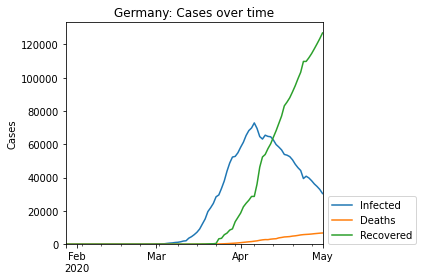

,Date,Confirmed,Infected,Deaths,Recovered
90,2020-04-27,158758,38132,6126,114500
91,2020-04-28,159912,36198,6314,117400
92,2020-04-29,161539,34672,6467,120400
93,2020-04-30,163009,32886,6623,123500
94,2020-05-01,164077,30441,6736,126900


In [11]:
ger_scenario.show_record().tail()

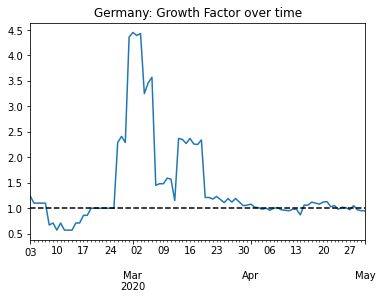

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-05-01,Crossroad,0,3


In [12]:
ger_scenario.growth_factor()

In [13]:
result.loc[result['Date'] == '2020-02-25']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
28,2020-02-25,17,3,0,14,Germany,None,61504


In [14]:
result.loc[result['Date'] == '2020-04-13']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
76,2020-04-13,130072,62578,3194,64300,Germany,None,1317887


# SIR MODEL

In [15]:
ger_scenario.set_phase(
    start_dates=["20Mar2020", "1Apr2020","13Apr2020"],
    population=82790000
)

,start_date,end_date,population
1st,20Mar2020,31Mar2020,82790000
2nd,1Apr2020,12Apr2020,82790000
3rd,13Apr2020,-,82790000


In [16]:
ger_scenario.estimate(model.SIR)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Total: 0 min 22 sec.


In [17]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,rho,sigma,Rt,score,1/beta [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,1093,0.119697,0.028029,4.27,0.387431,6,27
2nd,1Apr2020,12Apr2020,82790000,1093,0.060590,0.050769,1.19,0.073209,12,14
3rd,13Apr2020,-,82790000,1093,0.032491,0.061101,0.53,0.019351,23,12


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


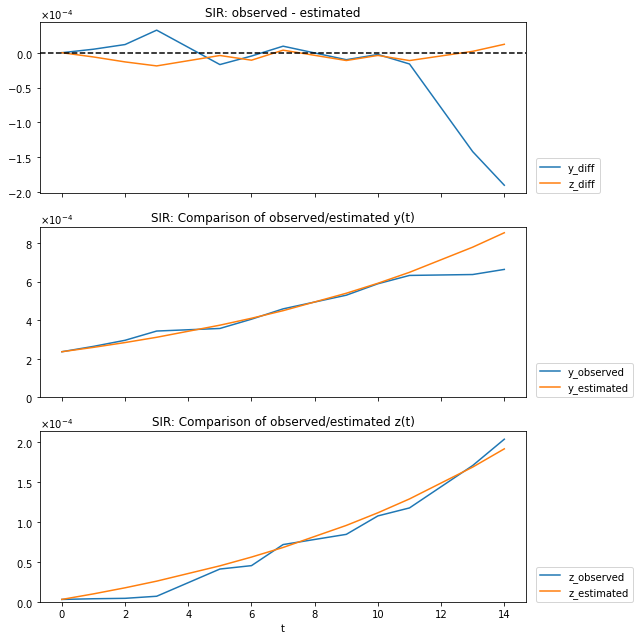

In [18]:
ger_scenario.accuracy_graph(phase_n=1)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


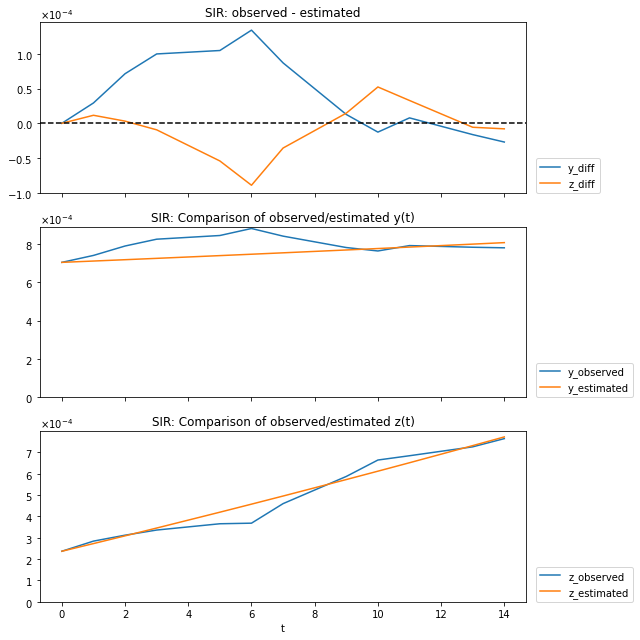

In [19]:
ger_scenario.accuracy_graph(phase_n=2)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


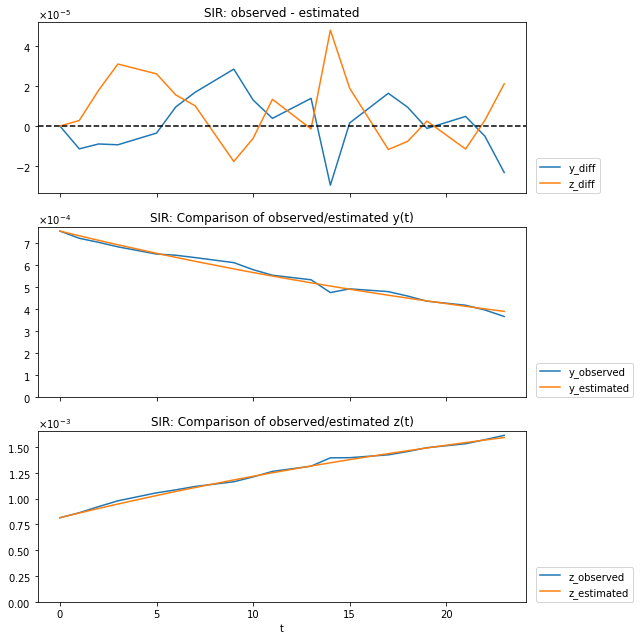

In [20]:
ger_scenario.accuracy_graph(phase_n=3)

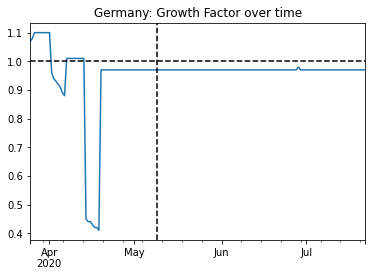

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-21 17:19:00,Stopping,0,131


In [21]:
ger_scenario.growth_factor(days_to_predict=100)

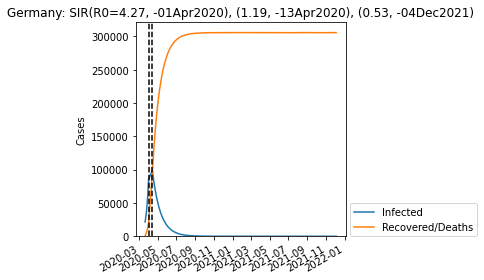

In [22]:
df_sir = ger_scenario.predict(days=600)

In [23]:
df_sir.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered/Deaths
Time,,,
2020-05-02 06:21:00,82538747,48376,202875
2020-05-03 00:34:00,82537200,47005,205794
2020-05-03 18:47:00,82535695,45671,208632
2020-05-04 13:00:00,82534233,44375,211391
2020-05-05 07:13:00,82532811,43115,214073
2020-05-06 01:26:00,82531429,41890,216680
2020-05-06 19:39:00,82530086,40699,219213
2020-05-07 13:52:00,82528781,39542,221675
2020-05-08 08:05:00,82527513,38418,224067


# SIRD MODEL

D stands for Deaths, in this model we separate two different groups. previosuly R = Deaths + actual recovers 

In [24]:
ger_scenario.set_phase(
    start_dates=["20Mar2020", "1Apr2020","13Apr2020"],
    population=82790000
)

,start_date,end_date,population
1st,20Mar2020,31Mar2020,82790000
2nd,1Apr2020,12Apr2020,82790000
3rd,13Apr2020,-,82790000


In [25]:
ger_scenario.estimate(model.SIRD)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Total: 0 min 25 sec.


In [26]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,kappa,rho,sigma,Rt,score,1/alpha2 [day],1/beta [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,723,0.000770,0.073085,0.016468,4.24,0.420727,651,6,30
2nd,1Apr2020,12Apr2020,82790000,723,0.001664,0.038633,0.032043,1.15,0.083572,301,12,15
3rd,13Apr2020,-,82790000,723,0.002335,0.021731,0.038163,0.54,0.024067,215,23,13


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


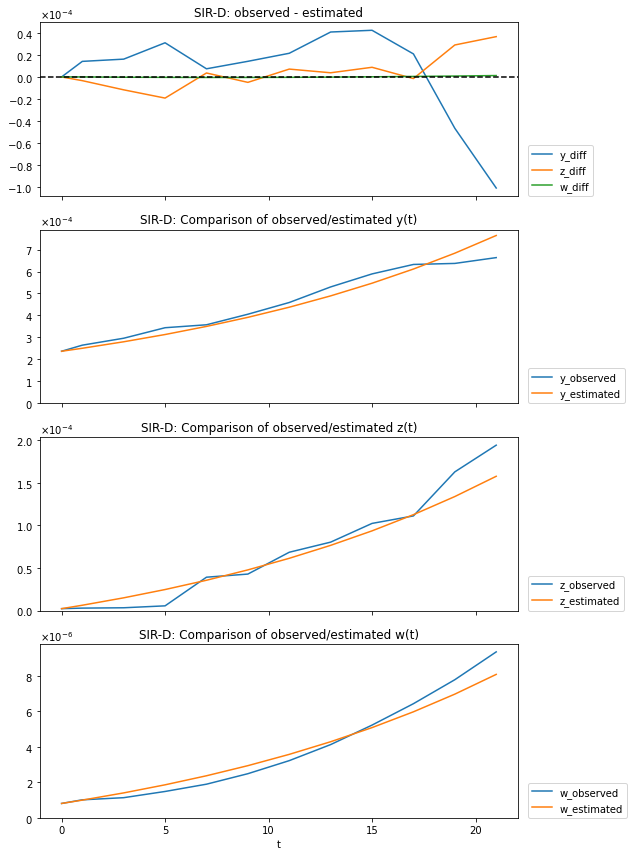

In [27]:
ger_scenario.accuracy_graph(phase_n=1)

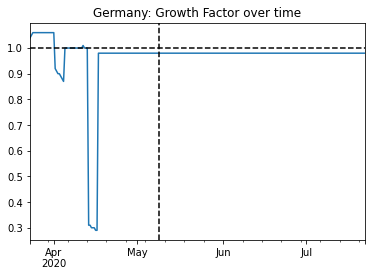

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-22 00:21:00,Stopping,0,199


In [28]:
ger_scenario.growth_factor(days_to_predict=100)

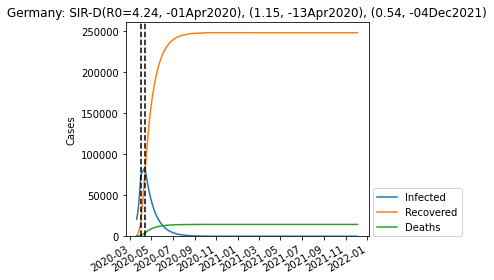

In [29]:
df_sird = ger_scenario.predict(days=600)

In [30]:
df_sird.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Deaths
Time,,,,
2020-05-02 04:18:00,82574914,41099,164654,9331
2020-05-02 16:21:00,82574027,40328,166216,9426
2020-05-03 04:24:00,82573157,39572,167749,9520
2020-05-03 16:27:00,82572303,38830,169253,9612
2020-05-04 04:30:00,82571464,38102,170729,9702
2020-05-04 16:33:00,82570642,37388,172177,9791
2020-05-05 04:36:00,82569835,36687,173597,9878
2020-05-05 16:39:00,82569044,36000,174991,9963
2020-05-06 04:42:00,82568267,35326,176358,10047


# SIRF MODEL

F = Deaths + people that might die without be classified as infected

In [31]:
ger_scenario.estimate(model.SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 16 sec.
		100 trials finished in 0 min 17 sec.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 23 sec.
		100 trials finished in 0 min 22 sec.
		100 trials finished in 0 min 23 sec.
	Estimator will be replaced because it is incapable of improvement.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 16 sec.
		100 trials finished in 0 min 18 sec.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0

In [32]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,890,0.005228,0.000686,0.082875,0.033796,2.39,0.617248,0.005,900,7,18
2nd,1Apr2020,12Apr2020,82790000,890,0.005823,0.001509,0.046956,0.046324,0.98,0.134659,0.006,409,13,13
3rd,13Apr2020,-,82790000,890,0.068325,0.001419,0.020571,0.041023,0.45,0.036841,0.068,435,30,15


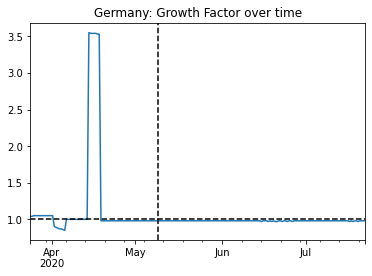

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-22 05:30:00,Stopping,0,154


In [33]:
ger_scenario.growth_factor(days_to_predict=100)

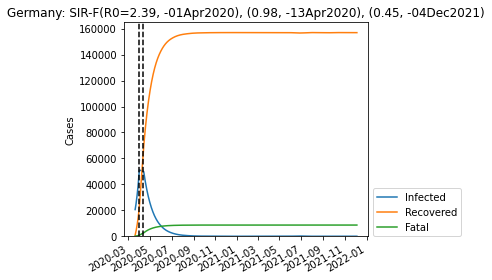

In [34]:
df_seird = ger_scenario.predict(days=600)

In [35]:
df_seird.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Fatal,Confirmed
Time,,,,,
2020-05-02 06:20:00,82646205,24794,113359,5641,143794
2020-05-02 21:10:00,82645700,24221,114366,5710,144297
2020-05-03 12:00:00,82645207,23662,115351,5778,144791
2020-05-04 02:50:00,82644725,23114,116314,5844,145272
2020-05-04 17:40:00,82644254,22579,117256,5909,145744
2020-05-05 08:30:00,82643793,22056,118177,5972,146205
2020-05-05 23:20:00,82643342,21545,119077,6034,146656
2020-05-06 14:10:00,82642902,21045,119957,6095,147097
2020-05-07 05:00:00,82642472,20556,120816,6154,147526


# SEWIRF

E - exposed - people that are susspected to be infected
W - waiting - waiting for the test results if the person is infected

In [36]:
ger_scenario.estimate(model.SEWIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 16 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 22 sec.
		100 trials finished in 0 min 24 sec.
		100 trials finished in 0 min 27 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 21 sec.
		100 trials finished in 0 m

In [37]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho1,rho2,rho3,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta1 [day],1/beta2 [day],1/beta3 [day],1/gamma [day]
1st,20Mar2020,31Mar2020,82790000,1116,0.001351,0.001105,0.319029,0.394761,0.137364,0.034447,8.96,0.512711,0.001,701,2,1,5,22
2nd,1Apr2020,12Apr2020,82790000,1116,0.038475,0.000239,0.084296,0.740105,0.472604,0.044876,1.80,0.144270,0.038,3243,9,1,1,17
3rd,13Apr2020,-,82790000,1116,0.135149,0.000597,0.035901,0.239611,0.354707,0.056023,0.55,0.094134,0.135,1299,21,3,2,13


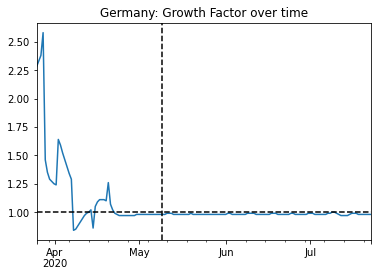

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Germany,2020-07-22 18:36:00,Stopping,0,17


In [38]:
ger_scenario.growth_factor(days_to_predict=100)

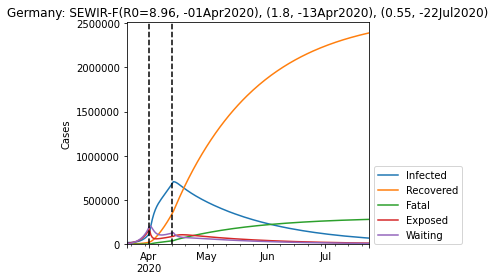

In [39]:
df_sewirf = ger_scenario.predict(days=100)

In [40]:
df_sewirf.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Fatal,Exposed,Waiting,Confirmed
Time,,,,,,,
2020-05-02 09:36:00,80896364,463511,1154711,134167,82584,58660,1752389
2020-05-03 04:12:00,80878211,455325,1180449,137227,81118,57667,1773001
2020-05-03 22:48:00,80860381,447288,1205734,140233,79675,56685,1793255
2020-05-04 17:24:00,80842868,439409,1230572,143189,78261,55697,1813170
2020-05-05 12:00:00,80825666,431706,1254969,146098,76879,54678,1832773
2020-05-06 06:36:00,80808770,424168,1278932,148960,75522,53644,1852060
2020-05-07 01:12:00,80792175,416763,1302473,151771,74188,52626,1871007
2020-05-07 19:48:00,80775876,409464,1325603,154530,72875,51649,1889597
2020-05-08 14:24:00,80759868,402257,1348330,157235,71581,50725,1907822


# comparison 

In [106]:
def getValuesVector(df, label):
    d = ''
    arr = []
    for index, row in df.loc['2020-05-02':'2020-05-08'].iterrows():
        ind = str(index).split(" ")[0]
        if (d == ind):
            arr[-1] = round((arr[-1] + row[label]) / 2, 0)
        else:
            arr.append(row[label])
        d = ind
    return arr

def getComparison(df_sewirf, df_seird, df_sird, df_sir, label):
    fit = linear_model.fitFuntion(training, label)
    x, y = linear_model.getDataSet(result, label)
    func = fit['function']
    popt = fit['popt']
     
    df = pd.DataFrame()
    df["sewirf_" + label] = getValuesVector(df_sewirf.loc['2020-05-02':'2020-05-08'], label)
    df["sirf_" + label] = getValuesVector(df_seird.loc['2020-05-02':'2020-05-08'], label)
    df["sird_" + label] = getValuesVector(df_sird.loc['2020-05-02':'2020-05-08'], label)
    df["sir_" + label] = getValuesVector(df_sir.loc['2020-05-02':'2020-05-08'], label)
    df["function_fit_" + label] = func(x, *popt)[-8:-1]
    df[label] = list(test[label])
    
    squareError = pd.DataFrame()
    squareError["sewirf_" + label] = np.square(list(df["sewirf_" + label] - df[label]))
    squareError["sirf_" + label] = np.square(list(df["sirf_" + label] - df[label]))
    squareError["sird_" + label] = np.square(list(df["sird_" + label] - df[label]))
    squareError["sir_" + label] = np.square(list(df["sir_" + label] - df[label]))
    squareError["function_fit_" + label] = np.square(list(df["function_fit_" + label] - df[label]))

    return (df, squareError)

## Infected

In [112]:
comp, squareError = getComparison(df_sewirf, df_seird, df_sird, df_sir, "Infected")

In [113]:
comp

,sewirf_Infected,seird_Infected,sird_Infected,sir_Infected,function_fit_Infected,Infected
0,463511.0,24508.0,40714.0,48376.0,16917.150574,29155
1,451306.0,23662.0,39201.0,46338.0,10816.576513,28198
2,439409.0,22846.0,37745.0,44375.0,4280.351405,26459
3,431706.0,21800.0,36344.0,43115.0,-2702.381163,24914
4,424168.0,21045.0,34995.0,41294.0,-10142.477605,20987
5,413114.0,20318.0,33696.0,39542.0,-18050.794336,20338
6,402257.0,19613.0,32448.0,38418.0,-26438.187768,21378


In [114]:
squareError

,sewirf_Infected,seird_Infected,sird_Infected,sir_Infected,function_fit_Infected
0,1.886651e+11,21594609.0,133610481.0,369446841.0,1.497650e+08
1,1.790204e+11,20575296.0,121066009.0,329059600.0,3.021139e+08
2,1.705277e+11,13053769.0,127373796.0,320983056.0,4.918925e+08
3,1.654797e+11,9696996.0,130644900.0,331276401.0,7.626645e+08
4,1.625549e+11,3364.0,196224064.0,412374249.0,9.690444e+08
5,1.542730e+11,400.0,178436164.0,368793616.0,1.473700e+09
6,1.450688e+11,3115225.0,122544900.0,290361600.0,2.286388e+09


# conclusions

As we can see the SIRF model turned out to be most suitable solution for modeling epidemy in germany, SIR-based approach tends to give bigger number of cases than actual, while naive approach tends to predict less than real value. Fitting function turned out to give results worse than most of SIR models (SIR, SIRF, SIRD), but was much better than SEWIRF, which turned out to be to complex for this domain. It is important to know that not every SIR-like model is proper to model every epidemy since each ilness have its characteristic properties.

SIRF could provide some useful data here since the best predictions differed from real data by 30 infections. 

Function fitting is very naive but can give not bad short term predictions, but is definitly to simple for more complex purposes

the project can be enchanced by finding additional data which have corelation with infections, but this data is more country specific than global prediction

also if it is possible project can be extended by trying other classifiers/ regressors to predict infections and deaths caused by covid-19